# Intro:
    
The biggest challenge of Factoring is to predict if and when invoices will be paid.

The factor provides funds against this future payment to the business by buying their invoice.

The factor then collects the payment and charges their interest rate.

If the invoice isn't paid, the factor loses their advanced funds.

# About Data:

This data was provided by private company

https://www.kaggle.com/datasets/hhenry/finance-factoring-ibm-late-payment-histories?resource=download

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
pay = pd.read_csv('Payment.csv')

In [4]:
pay.head()

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate
0,391,0379-NEVHP,4/6/2013,611365,1/2/2013,2/1/2013,55.94,No,1/15/2013,Paper,13,0
1,406,8976-AMJEO,3/3/2012,7900770,1/26/2013,2/25/2013,61.74,Yes,3/3/2013,Electronic,36,6
2,391,2820-XGXSB,1/26/2012,9231909,7/3/2013,8/2/2013,65.88,No,7/8/2013,Electronic,5,0
3,406,9322-YCTQO,4/6/2012,9888306,2/10/2013,3/12/2013,105.92,No,3/17/2013,Electronic,35,5
4,818,6627-ELFBK,11/26/2012,15752855,10/25/2012,11/24/2012,72.27,Yes,11/28/2012,Paper,34,4


In [5]:
pay.groupby('customerID')['countryCode'].count().sort_values()


customerID
2621-XCLEH    15
0187-ERLSR    16
7245-CKNCN    17
3676-CQAIF    17
4632-QZOKX    17
              ..
9286-VLKMI    34
0688-XNJRO    34
4640-FGEJI    35
8887-NCUZC    35
9149-MATVB    36
Name: countryCode, Length: 100, dtype: int64

In [6]:
pay['PaperlessDate'] = pd.to_datetime(pay['PaperlessDate'])
pay['InvoiceDate'] = pd.to_datetime(pay['InvoiceDate'])
pay['DueDate'] = pd.to_datetime(pay['DueDate'])
pay['SettledDate'] = pd.to_datetime(pay['SettledDate'])
pay['countryCode'] = pay['countryCode'].astype(str)
pay['PaymentTerm'] = (pay['DueDate'] - pay['InvoiceDate']).dt.days

In [7]:
pay.loc[pay['DaysLate']==0,'CustomerSegment'] = 'on time'
pay.loc[pay['DaysLate']>0,'CustomerSegment'] = 'fraud risk'

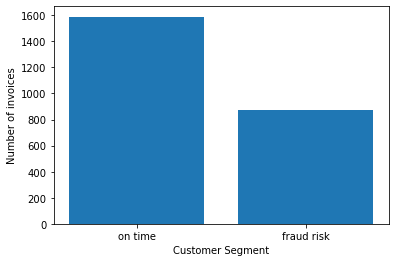

In [8]:
category_count=pay.groupby('CustomerSegment').count().sort_values(by='customerID', ascending=False)
plt.bar(category_count.index.values, category_count['customerID'])
plt.xlabel('Customer Segment')
plt.ylabel('Number of invoices')
plt.show()

In [9]:
pay = pay.sort_values(by=['customerID','InvoiceDate'])

In [10]:
pay = pay.drop(['PaperlessDate','invoiceNumber'],axis=1)

In [11]:
pay['late_invoices'] = np.where(pay['DaysLate'] > 0,1,0)
pay['late_invoice_Amt'] = np.where(pay['DaysLate'] > 0,pay['InvoiceAmount'],0)

In [12]:
import pandasql as ps

In [13]:
sqlcode = '''select *,sum(InvoiceAmount) over(partition by customerID order by InvoiceDate ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) as total_invoice_amt,
sum(late_invoice_Amt) over(partition by customerID order by InvoiceDate ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) as total_late_invoice_amt,
sum(late_invoices) over(partition by customerID order by InvoiceDate ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) as total_late_invoices,
count() over(partition by customerID order by InvoiceDate ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) as total_invoices
from pay'''

pay2 = ps.sqldf(sqlcode, locals())

In [14]:
pay2 = pay2.drop('late_invoices',axis=1)
pay2 = pay2.drop('late_invoice_Amt',axis=1)

In [15]:
pay2['late_invoice_amt_pct'] = pay2['total_late_invoice_amt']/pay2['total_invoice_amt']
pay2['late_invoices_pct'] = pay2['total_late_invoices']/pay2['total_invoices']

In [16]:
pay2 = pay2.replace(np.NaN,0)

In [17]:
pay2.head()

,countryCode,customerID,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate,PaymentTerm,CustomerSegment,total_invoice_amt,total_late_invoice_amt,total_late_invoices,total_invoices,late_invoice_amt_pct,late_invoices_pct
0,391,0187-ERLSR,2012-03-29 00:00:00.000000,2012-04-28 00:00:00.000000,62.68,Yes,2012-04-25 00:00:00.000000,Paper,27,0,30,on time,0.00,0.0,0.0,0,0.0,0.0
1,391,0187-ERLSR,2012-05-15 00:00:00.000000,2012-06-14 00:00:00.000000,77.19,No,2012-05-28 00:00:00.000000,Paper,13,0,30,on time,62.68,0.0,0.0,1,0.0,0.0
2,391,0187-ERLSR,2012-05-21 00:00:00.000000,2012-06-20 00:00:00.000000,51.65,No,2012-06-04 00:00:00.000000,Paper,14,0,30,on time,139.87,0.0,0.0,2,0.0,0.0
3,391,0187-ERLSR,2012-06-16 00:00:00.000000,2012-07-16 00:00:00.000000,64.47,Yes,2012-07-04 00:00:00.000000,Paper,18,0,30,on time,191.52,0.0,0.0,3,0.0,0.0
4,391,0187-ERLSR,2012-09-05 00:00:00.000000,2012-10-05 00:00:00.000000,84.57,No,2012-09-14 00:00:00.000000,Paper,9,0,30,on time,255.99,0.0,0.0,4,0.0,0.0


In [18]:
pay = pay2.drop(['countryCode','customerID','InvoiceDate','DueDate','SettledDate','DaysToSettle','DaysLate'],axis=1)

In [19]:
pay_x = pay.drop('CustomerSegment',axis=1)
pay_y = pay[['CustomerSegment']]

In [20]:
pay_x['Disputed'].value_counts()

No     1905
Yes     561
Name: Disputed, dtype: int64

In [21]:
pay_x['Disputed'] = np.where(pay_x['Disputed']=='Yes',1,0)

In [22]:
pay_x['PaperlessBill'].value_counts()

Paper         1263
Electronic    1203
Name: PaperlessBill, dtype: int64

In [23]:
pay_x['PaperlessBill'] = np.where(pay_x['PaperlessBill']=='Electronic',1,0)

In [24]:
pay_y['Segment'] = np.where(pay_y['CustomerSegment'] == 'fraud risk',1,0)

In [25]:
import scipy.misc

In [26]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix,precision_recall_fscore_support,accuracy_score

In [27]:
X_train, X_test,Y_train,Y_test = train_test_split(pay_x,pay_y[['Segment']],test_size=0.2,random_state=42)

target_names = ['on time', 'fraud risk']

n_classes = Y_train.shape[1]

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
param_grid = [{'C': [0.1,0.2,0.5,1,5,10],'penalty': ['l1', 'l2']}]

model = LogisticRegression()

model2 = GridSearchCV(model, param_grid,cv=5, n_jobs=-1,scoring='recall')
model2.fit(X_train_scaled,Y_train)
print(model2.best_params_)
print(model2.best_score_)

{'C': 0.2, 'penalty': 'l2'}
0.7418439716312056


In [30]:
clf = LogisticRegression(C=0.2,penalty='l2',random_state=42)
clf.fit(X_train_scaled, Y_train)

y_score = clf.predict_proba(X_test_scaled)

In [31]:
y_pred = clf.fit(X_train_scaled, Y_train).predict(X_test_scaled)
Logit_test = metrics.average_precision_score(Y_test, y_pred)
print("Logistic test score:",Logit_test)

Logistic test score: 0.6534893977831419


In [32]:
print(classification_report(Y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     on time       0.88      0.86      0.87       322
  fraud risk       0.74      0.77      0.76       172

    accuracy                           0.83       494
   macro avg       0.81      0.82      0.81       494
weighted avg       0.83      0.83      0.83       494



In [33]:
import scikitplot as skplt

In [64]:
#pip install scikit-plot

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       322
           1       0.74      0.77      0.76       172

    accuracy                           0.83       494
   macro avg       0.81      0.82      0.81       494
weighted avg       0.83      0.83      0.83       494

Accuracy: 0.8279352226720648
Precision: 0.8298222996252987
Recall: 0.8279352226720648
F score: 0.8287055574504968


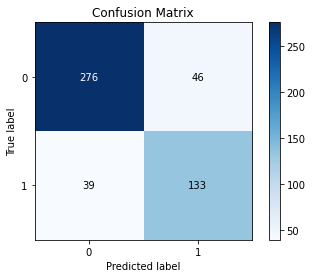

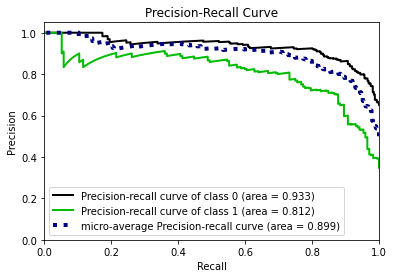

In [34]:
conf_mat = confusion_matrix(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)
score = precision_recall_fscore_support(Y_test, y_pred, average='weighted')
precision, recall, fscore, k = score
skplt.metrics.plot_confusion_matrix(Y_test, y_pred)
skplt.metrics.plot_precision_recall_curve(Y_test, y_score)
print(classification_report(Y_test, y_pred))
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F score:",fscore)

In [69]:
#pip install xgboost

In [35]:
from xgboost import XGBClassifier
params = {'n_estimators':[250,500,750],'learning_rate':[0.001,0.01,0.1],'max_depth':[1,2,3,4,5,6]}

xgb2 = XGBClassifier(random_state=42)
clf = GridSearchCV(xgb2,params,cv=3,scoring='recall')
clf.fit(X_train, Y_train)

print(clf.best_params_)
print(clf.best_score_)

{'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 250}
0.7886524822695035


In [36]:
clf = XGBClassifier(n_estimators=250,learning_rate=0.001,max_depth=2,random_state=42)
clf.fit(X_train, Y_train)

y_score = clf.predict_proba(X_test)

In [37]:
y_pred = clf.fit(X_train, Y_train).predict(X_test)
xgb_test = metrics.average_precision_score(Y_test, y_pred)
print("XGB test score:",xgb_test)

XGB test score: 0.6394747303560033


In [38]:
print(classification_report(Y_test, y_pred, target_names=target_names))


              precision    recall  f1-score   support

     on time       0.86      0.86      0.86       322
  fraud risk       0.74      0.74      0.74       172

    accuracy                           0.82       494
   macro avg       0.80      0.80      0.80       494
weighted avg       0.82      0.82      0.82       494



              precision    recall  f1-score   support

           0       0.86      0.86      0.86       322
           1       0.74      0.74      0.74       172

    accuracy                           0.82       494
   macro avg       0.80      0.80      0.80       494
weighted avg       0.82      0.82      0.82       494

Accuracy: 0.819838056680162
Precision: 0.8195992083885191
Recall: 0.819838056680162
F score: 0.8197150903618068


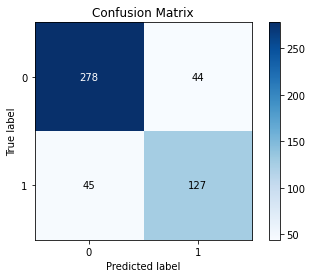

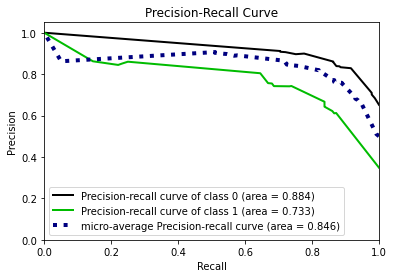

In [39]:
conf_mat = confusion_matrix(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)
score = precision_recall_fscore_support(Y_test, y_pred, average='weighted')
precision, recall, fscore, k = score
skplt.metrics.plot_confusion_matrix(Y_test, y_pred)
skplt.metrics.plot_precision_recall_curve(Y_test, y_score)
print(classification_report(Y_test, y_pred))
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F score:",fscore)

For the basic prediction of whenther an invoice will be late vs early, the logictic regression is able to give better predictions.

But some times just knowing whether an invoice is going to be late is not enough Business wants to know more about how much fraud risky can be expected so they can prioritize invoices that needs to be followed up early.

Hence taking the analysis a bit further by dividing the late class into 2 sub classes fruad risk and more fraud risk based on the distribution's median value

In [40]:
pay = pd.read_csv('Payment.csv')

In [41]:
pay.loc[pay['DaysLate']==0,'CustomerSegment'] = 'on time'
pay.loc[(pay['DaysLate']>0) & (pay['DaysLate']<11),'CustomerSegment'] = 'fraud risk'
pay.loc[pay['DaysLate']>10,'CustomerSegment'] = 'more fraud risk'

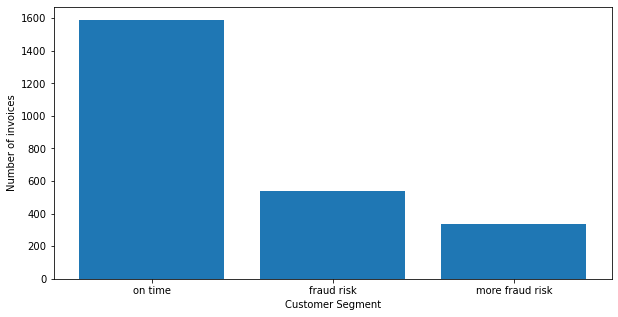

In [42]:
category_count=pay.groupby('CustomerSegment').count().sort_values(by='customerID', ascending=False)
fig = plt.subplots(figsize=(10,5))
plt.bar(category_count.index.values, category_count['customerID'])
plt.xlabel('Customer Segment')
plt.ylabel('Number of invoices')
plt.show()

In [43]:
pay = pay.sort_values(by=['customerID','InvoiceDate'])


In [44]:
pay = pay.drop(['PaperlessDate','invoiceNumber'],axis=1)


In [45]:
pay['late_invoices'] = np.where(pay['DaysLate'] > 0,1,0)
pay['late_invoice_Amt'] = np.where(pay['DaysLate'] > 0,pay['InvoiceAmount'],0)

In [46]:
import pandasql as ps

In [47]:
sqlcode = '''select *,sum(InvoiceAmount) over(partition by customerID order by InvoiceDate ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) as total_invoice_amt,
sum(late_invoice_Amt) over(partition by customerID order by InvoiceDate ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) as total_late_invoice_amt,
sum(late_invoices) over(partition by customerID order by InvoiceDate ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) as total_late_invoices,
count() over(partition by customerID order by InvoiceDate ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) as total_invoices
from pay'''

pay2 = ps.sqldf(sqlcode, locals())

In [48]:
pay2 = pay2.drop('late_invoices',axis=1)
pay2 = pay2.drop('late_invoice_Amt',axis=1)

In [49]:
pay2['late_invoice_amt_pct'] = pay2['total_late_invoice_amt']/pay2['total_invoice_amt']
pay2['late_invoices_pct'] = pay2['total_late_invoices']/pay2['total_invoices']

In [50]:
pay2 = pay2.replace(np.NaN,0)

In [51]:
pay = pay2.drop(['countryCode','customerID','InvoiceDate','DueDate','SettledDate','DaysToSettle','DaysLate'],axis=1)

In [52]:
pay_x = pay.drop('CustomerSegment',axis=1)
pay_y = pay[['CustomerSegment']]

In [53]:
pay_x['Disputed'] = np.where(pay_x['Disputed']=='Yes',1,0)

In [54]:
pay_x['PaperlessBill'] = np.where(pay_x['PaperlessBill']=='Electronic',1,0)

In [55]:
pay_y.loc[pay_y['CustomerSegment'] == 'on time','Segment'] = 0
pay_y.loc[pay_y['CustomerSegment'] == 'fraud risk','Segment'] = 1
pay_y.loc[pay_y['CustomerSegment'] == 'more fraud risk','Segment'] = 2

In [56]:
X_train, X_test,Y_train,Y_test = train_test_split(pay_x,pay_y[['Segment']],test_size=0.2,random_state=42)

target_names = ['on time', 'fraud risk', 'more fraud risk']

n_classes = Y_train.shape[1]

In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [58]:
scorer = sklearn.metrics.make_scorer(sklearn.metrics.precision_score, average = 'weighted')

# Logistic Regression


In [59]:
param_grid = [{'C': [0.1,0.2,0.5,1,5,10],'penalty': ['l1', 'l2']}]

l_clf = LogisticRegression()

model2 = GridSearchCV(l_clf, param_grid,cv=5, n_jobs=-1,scoring=scorer)
model2.fit(X_train_scaled,Y_train)
print(model2.best_params_)
print(model2.best_score_)

{'C': 10, 'penalty': 'l2'}
0.7442679155302449


In [60]:
l_clf = LogisticRegression(C=0.1,penalty='l2',random_state=42)
l_clf.fit(X_train_scaled, Y_train)

y_score = l_clf.predict_proba(X_test_scaled)

              precision    recall  f1-score   support

         0.0       0.83      0.93      0.88       315
         1.0       0.53      0.46      0.49       114
         2.0       0.76      0.48      0.58        65

    accuracy                           0.76       494
   macro avg       0.70      0.62      0.65       494
weighted avg       0.75      0.76      0.75       494

Accuracy: 0.7611336032388664
Precision: 0.748472607945857
Recall: 0.7611336032388664
F score: 0.7481783851553137


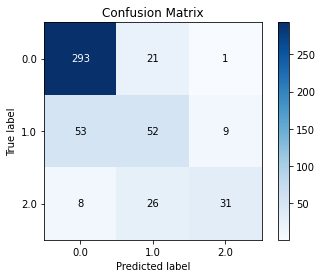

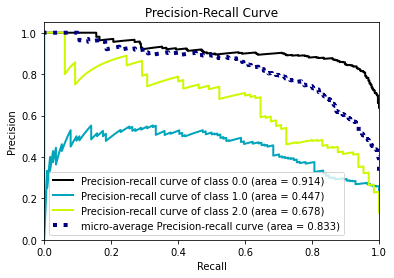

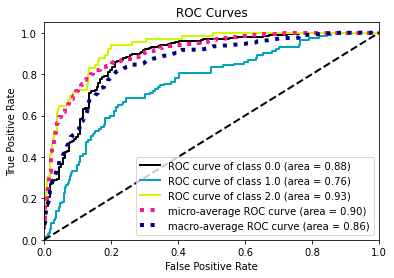

In [61]:
y_pred = l_clf.predict(X_test_scaled)
conf_mat = confusion_matrix(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)
score = precision_recall_fscore_support(Y_test, y_pred, average='weighted')
precision, recall, fscore, k = score
skplt.metrics.plot_confusion_matrix(Y_test, y_pred)
skplt.metrics.plot_precision_recall_curve(Y_test, y_score)
skplt.metrics.plot_roc_curve(Y_test, y_score)
print(classification_report(Y_test, y_pred))
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F score:",fscore)

# KNN Classifier

In [62]:
from sklearn import neighbors
param_grid_k = [{'n_neighbors': range(1,100),'weights': ["uniform", "distance"]}]

knn_clfs = neighbors.KNeighborsClassifier()
grid_search1 = GridSearchCV(knn_clfs, param_grid_k, cv=5, n_jobs=-1,scoring=scorer)
grid_search1.fit(X_train_scaled, Y_train)
print(grid_search1.best_params_)
print(grid_search1.best_score_)

{'n_neighbors': 30, 'weights': 'distance'}
0.738760474789423


In [63]:
clf = OneVsRestClassifier(neighbors.KNeighborsClassifier(n_neighbors=36,weights='distance'))
clf.fit(X_train_scaled, Y_train)

y_score = clf.predict_proba(X_test_scaled)

              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87       315
         1.0       0.50      0.47      0.49       114
         2.0       0.69      0.45      0.54        65

    accuracy                           0.75       494
   macro avg       0.68      0.61      0.63       494
weighted avg       0.74      0.75      0.74       494

Accuracy: 0.7510121457489879
Precision: 0.7396157578956613
Recall: 0.7510121457489879
F score: 0.7405934069002489


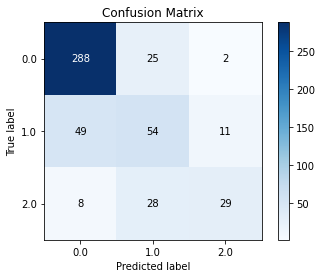

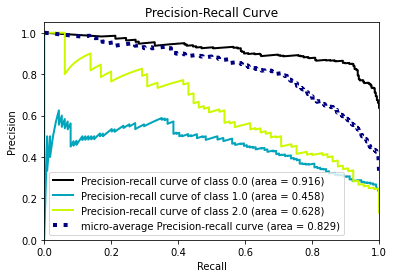

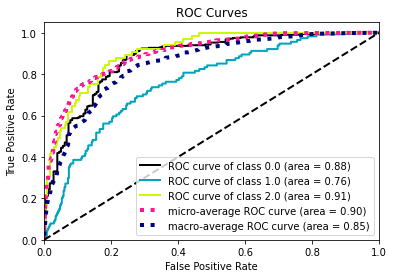

In [64]:
y_pred = clf.fit(X_train_scaled, Y_train).predict(X_test_scaled)
conf_mat = confusion_matrix(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)
score = precision_recall_fscore_support(Y_test, y_pred, average='weighted')
precision, recall, fscore, k = score
skplt.metrics.plot_confusion_matrix(Y_test, y_pred)
skplt.metrics.plot_precision_recall_curve(Y_test, y_score)
skplt.metrics.plot_roc_curve(Y_test, y_score)
print(classification_report(Y_test, y_pred))
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F score:",fscore)

# Decision Trees


In [65]:
# Tree Regression
from sklearn import tree

param_grid_t = [{'max_depth': range(1,20), 'min_samples_split': range(2,20)}]

tree_clf = tree.DecisionTreeClassifier()
grid_search1 = GridSearchCV(tree_clf, param_grid_t, cv=5, n_jobs=-1,scoring=scorer)
grid_search1.fit(X_train, Y_train)
print(grid_search1.best_params_)
print(grid_search1.best_score_)

{'max_depth': 3, 'min_samples_split': 2}
0.7470859192372016


In [66]:
d_clf = OneVsRestClassifier(tree.DecisionTreeClassifier(max_depth=3,min_samples_split=2))
d_clf.fit(X_train, Y_train)

y_score = d_clf.predict_proba(X_test)

              precision    recall  f1-score   support

         0.0       0.82      0.91      0.86       315
         1.0       0.49      0.43      0.46       114
         2.0       0.69      0.45      0.54        65

    accuracy                           0.74       494
   macro avg       0.66      0.60      0.62       494
weighted avg       0.72      0.74      0.73       494

Accuracy: 0.7388663967611336
Precision: 0.7241943029111828
Recall: 0.7388663967611336
F score: 0.7260787895627003


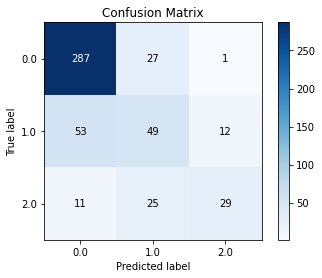

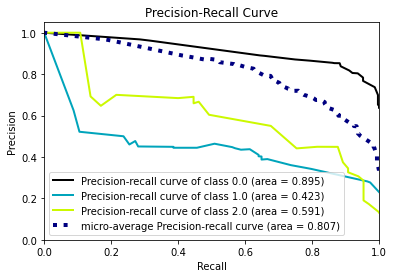

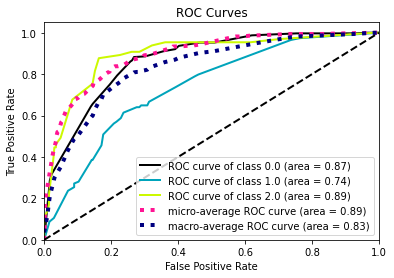

In [67]:
y_pred = d_clf.predict(X_test)
conf_mat = confusion_matrix(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)
score = precision_recall_fscore_support(Y_test, y_pred, average='weighted')
precision, recall, fscore, k = score
skplt.metrics.plot_confusion_matrix(Y_test, y_pred)
skplt.metrics.plot_precision_recall_curve(Y_test, y_score)
skplt.metrics.plot_roc_curve(Y_test, y_score)
print(classification_report(Y_test, y_pred))
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F score:",fscore)

# XGBoost

In [68]:
from xgboost import XGBClassifier
params = {'n_estimators':[250,500,750],'learning_rate':[0.001,0.01,0.1],'max_depth':[1,2,3,4,5,6]}

xgb2 = XGBClassifier(objective='multi:softmax',random_state=42)
clf = GridSearchCV(xgb2,params,cv=3,scoring=scorer)
clf.fit(X_train, Y_train)

print(clf.best_params_)
print(clf.best_score_)

{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 500}
0.7449370409269432


In [69]:
xgb_clf = OneVsRestClassifier(XGBClassifier(learning_rate=0.001,max_depth=3,n_estimators=250))
xgb_clf.fit(X_train, Y_train)

y_score = xgb_clf.predict_proba(X_test)

              precision    recall  f1-score   support

         0.0       0.82      0.91      0.86       315
         1.0       0.48      0.40      0.44       114
         2.0       0.66      0.48      0.55        65

    accuracy                           0.74       494
   macro avg       0.65      0.60      0.62       494
weighted avg       0.72      0.74      0.72       494

Accuracy: 0.7368421052631579
Precision: 0.7187478603029038
Recall: 0.7368421052631579
F score: 0.7235050333734545


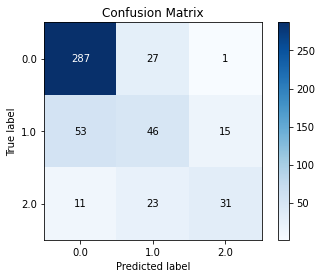

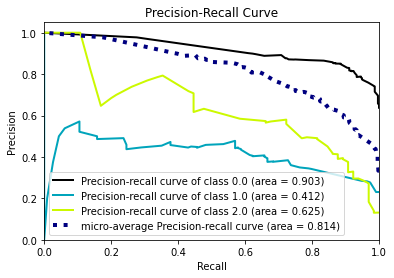

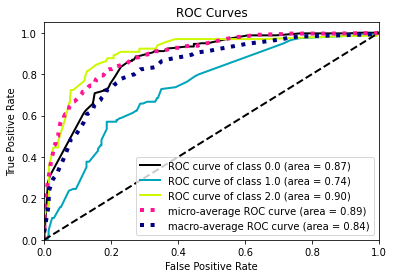

In [70]:
y_pred = xgb_clf.predict(X_test)
conf_mat = confusion_matrix(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)
score = precision_recall_fscore_support(Y_test, y_pred, average='weighted')
precision, recall, fscore, k = score
skplt.metrics.plot_confusion_matrix(Y_test, y_pred)
skplt.metrics.plot_precision_recall_curve(Y_test, y_score)
skplt.metrics.plot_roc_curve(Y_test, y_score)
print(classification_report(Y_test, y_pred))
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F score:",fscore)

In [71]:
feature_importance = pd.concat([pd.Series(X_train.columns),pd.Series(xgb_clf.estimators_[0].feature_importances_),pd.Series(xgb_clf.estimators_[1].feature_importances_)
           ,pd.Series(xgb_clf.estimators_[2].feature_importances_)],axis=1)

In [72]:
feature_importance.columns = ['Feature','On time','fraud risk','more fraud risk']


In [73]:
feature_importance

,Feature,On time,fraud risk,more fraud risk
0,InvoiceAmount,0.011732,0.000000,0.000000
1,Disputed,0.256327,0.168414,0.222474
2,PaperlessBill,0.022773,0.015593,0.042375
3,total_invoice_amt,0.008199,0.000000,0.015837
4,total_late_invoice_amt,0.000000,0.096523,0.000000
5,total_late_invoices,0.000010,0.000000,0.000000
6,total_invoices,0.000000,0.000000,0.000000
7,late_invoice_amt_pct,0.122593,0.094211,0.042183
8,late_invoices_pct,0.578366,0.625259,0.677130


# Conclusion

Looking at the performance from all the models, all models are doing a perfectly good job at predicting the on time payments invoices which is a good sign as we do not have to go after these invoices which can create a bad impression for our client and also waste valuable humna capital on something that will be paid on time.

From the other 2 late classes, the preformance has been comparable as everything is close, but XGBoost and decision trees are leading with a minor advantage and given that decision tree being a more simpler model i would go with that.